In [210]:
%pylab inline
import numpy as np
from sklearn import datasets 
from sklearn.cross_validation import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [211]:
class Linear(object):
    def __init__(self, n_in, n_out):
        self.W = np.random.randn(n_out, n_in)
        self.b = np.random.randn(n_out)
        
        self.input = np.zeros(n_in)
        self.output = np.zeros(n_out)
        
        self.gradInput = np.zeros_like(self.input)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.input = input
        self.output = np.dot(self.W, input) + self.b
        return self.output
    
    def updateGradInput(self, gradOutput):
        self.gradInput = np.dot(self.W.T, gradOutput)
        return self.gradInput
    
    def updateGradWeight(self, gradOutput):
        self.gradW = np.outer(gradOutput, self.input)
        self.gradb = gradOutput
        self.gradWeight = self.gradW, self.gradb
        
        return self.gradWeight

In [212]:
class Sigmoid(object):
    def __init__(self, n_in):
        self.input = np.zeros(n_in)
        self.output = np.zeros(n_in)
        self.gradInput = np.zeros_like(self.input)
        
    def updateOutput(self, input):
        self.input = input
        self.output = 1.0 / (1.0 + np.exp(-input))
        return self.output
    
    def updateGradInput(self, gradOutput):
        self.gradInput = gradOutput * self.output * (1.0 - self.output)
        return self.gradInput
    
    def updateGradWeight(self, gradOutput):
        self.gradWeight = ()
        return self.gradWeight

In [213]:
class Softmax(object):
    def __init__(self, n_in):
        self.output = np.zeros(n_in)
    
    def updateOutput(self, input):
        mx = input.max()
        logsum = np.exp(-(mx - input)).sum()
        logsum = mx + log(logsum)
        self.output = input - logsum
        
        return self.output
    
    def updateGradInput(self, gradOutput):
        sm = gradOutput.sum()
        self.gradInput = gradOutput - np.exp(self.output) * sm
        return self.gradInput
    
    def updateGradWeight(self, gradOutput):
        self.gradWeight = ()
        return self.gradWeight

In [214]:
class MSELoss(object):
    def __init__(self, n_in):
        self.n_in = n_in
        self.output = 0.0
        self.input = np.zeros(n_in)
        
    def updateOutput(self, input, target):
        self.output = (1.0 / self.n_in) *np.sum((input - target)**2)
        return self.output
    
    def updateGradInput(self, input, target):
        self.gradInput = (2.0 / self.n_in) * (input - target)
        return self.gradInput

In [215]:
class NLLLoss(object):
    def __init__(self, n_in):
        self.n_in = n_in
        
    def updateOutput(self, input, target):
        self.output = -input[target]
        return self.output
    
    def updateGradInput(self, input, target):
        self.gradInput = np.zeros_like(input)
        self.gradInput[target] = -1.0
        return self.gradInput

In [216]:
class MLP(object):
    def __init__(self, n_in, n_out):
        self.modules = []
        self.input = np.zeros(n_in)
        self.output = np.zeros(n_out)
        self.gradInput = np.zeros_like(self.input)
        self.gradients = []
        
    def add(self, module):
        self.modules.append(module)
        
    def forward(self, input):
        self.input = input
        self.output = input
        for m in self.modules:
            self.output = m.updateOutput(self.output)
        return self.output
    
    def backward(self, gradOutput):
        for m in reversed(self.modules):
            self.gradients.insert(0, m.updateGradWeight(gradOutput))
            gradOutput = m.updateGradInput(gradOutput)
        return self.gradients
    
    def predict(self, input):
        out = self.forward(input).argmax()
        return out
        #if out <= 0.5:
        #    return 0
        #return 1

In [217]:
model = MLP(2, 1)
model.add(Linear(2,500))
model.add(Sigmoid(500))
model.add(Linear(500,3))
model.add(Softmax(3))
criterion = NLLLoss(2)

model2 = MLP(2, 1)
model2.add(Linear(2,600))
model2.add(Sigmoid(600))
model2.add(Linear(600,3))
model2.add(Softmax(3))
criterion2 = NLLLoss(2)


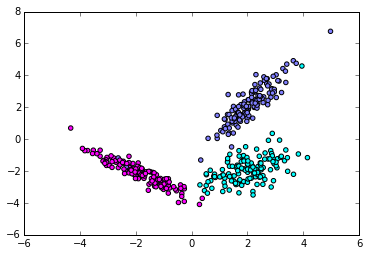

In [218]:
(easy_x, easy_y) = datasets.make_classification(n_samples=400, n_features = 2, n_classes = 3, n_informative = 2,
                             n_redundant = 0, n_repeated = 0, n_clusters_per_class=1, class_sep=2)
scatter(easy_x[:,0], easy_x[:,1], c = easy_y, cmap = 'cool')

In [219]:
training_setX, split_setX, training_setY, split_setY = train_test_split(easy_x, easy_y, test_size = 0.20, random_state = 0)
valid_setX, test_setX, valid_setY, test_setY = train_test_split(easy_x, easy_y, test_size = 0.50, random_state = 0)

In [220]:
# training
for i in range(100):
    for j in range(training_setX.shape[0]):
        prediction = model.forward(training_setX[j])
        err = criterion.updateOutput(prediction, training_setY[j])
        df_do = criterion.updateGradInput(prediction, training_setY[j])
        grads = model.backward(df_do)
        
        for k,m in enumerate(model.modules):
            if m.gradWeight != ():
                m.W -= 1e-3 * grads[k][0]
                m.b -= 1e-3 * grads[k][1]
                
    for j in range(training_setX.shape[0]):
        prediction2 = model2.forward(training_setX[j])
        err2 = criterion2.updateOutput(prediction2, training_setY[j])
        df_do2 = criterion2.updateGradInput(prediction2, training_setY[j])
        grads2 = model2.backward(df_do2)
        
        for k,m in enumerate(model2.modules):
            if m.gradWeight != ():
                m.W -= 1e-3 * grads2[k][0]
                m.b -= 1e-3 * grads2[k][1]

In [221]:
# validation
totalErr = 0.0
totalErr2 = 0.0
for i in range(valid_setX.shape[0]):
    prediction = model.forward(valid_setX[i])
    err = criterion.updateOutput(prediction, valid_setY[i])
    totalErr += err
    
    prediction2 = model2.forward(valid_setX[i])
    err2 = criterion2.updateOutput(prediction2, valid_setY[i])
    totalErr2 += err2

# testing
for i in range(test_setX.shape[0]):
    prediction = model.forward(test_setX[i])
    err = criterion.updateOutput(prediction, test_setY[i])
    totalErr += err
    
    prediction2 = model2.forward(test_setX[i])
    err2 = criterion2.updateOutput(prediction2, test_setY[i])
    totalErr2 += err2
print totalErr
print totalErr2

17.274887097
17.9360534477


In [222]:
if totalErr < totalErr2:
    bestModel = model
else:
    bestModel = model2

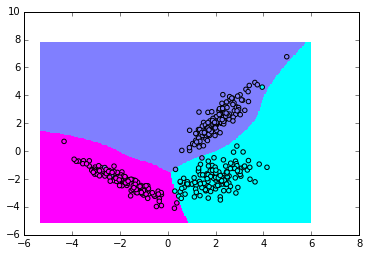

In [223]:
h = 0.05 # mesh size
x_min, x_max = easy_x[:, 0].min() - 1, easy_x[:,0].max() + 1
y_min, y_max = easy_x[:, 1].min() - 1, easy_x[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = []
for pt in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(bestModel.predict(pt))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)
figure()
pcolormesh(xx,yy, Z, cmap='cool')

scatter(easy_x[:,0], easy_x[:,1], c=easy_y, cmap='cool')

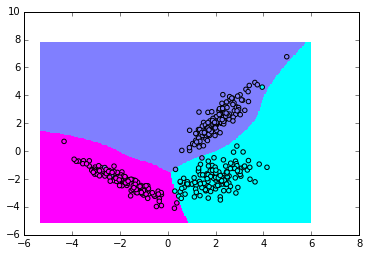

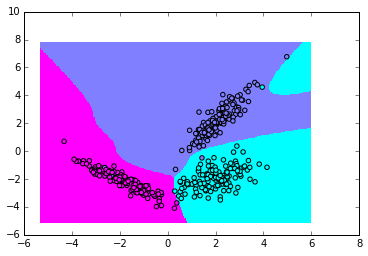

In [224]:
# Two model Comparison

# Model 1
h = 0.05 # mesh size
x_min, x_max = easy_x[:, 0].min() - 1, easy_x[:,0].max() + 1
y_min, y_max = easy_x[:, 1].min() - 1, easy_x[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = []
for pt in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(model.predict(pt))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)
figure()
pcolormesh(xx,yy, Z, cmap='cool')

scatter(easy_x[:,0], easy_x[:,1], c=easy_y, cmap='cool')

# Model 2
h = 0.05 # mesh size
x_min, x_max = easy_x[:, 0].min() - 1, easy_x[:,0].max() + 1
y_min, y_max = easy_x[:, 1].min() - 1, easy_x[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = []
for pt in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(model2.predict(pt))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)
figure()
pcolormesh(xx,yy, Z, cmap='cool')

scatter(easy_x[:,0], easy_x[:,1], c=easy_y, cmap='cool')